In [1]:
class plotmethod():
    def __init__(self, filename, plottime, rollingwindow, peak_rollingwindow, since = '', end = '', mikudashi = ''):
        self.since = since
        self.end = end
        self.filename = filename
        self.mikudashi = mikudashi
        self.name = ''
        self.plottime = plottime
        self.rollingwindow = rollingwindow
        self.peak_rollingwindow = peak_rollingwindow
        self.df = self.dfmake()
        """if self.since.hour >= 18 & self.since.hour < 24:#18~23時までの処理(24時からグリッド線)
            since = self.since + timedelta(hours = 24 - self.since.hour, minutes = -self.since.minute, seconds = -self.since.second)
        elif self.since.hour >= 12 & self.since.hour < 18:#12~17時までの処理(18時からグリッド線)
            since = self.since + timedelta(hours = 18 - self.since.hour, minutes = -self.since.minute, seconds = -self.since.second)
        elif self.since.hour >= 6 & self.since.hour < 12:#6~11時までの処理(12時からグリッド線)
            since = self.since + timedelta(hours = 12 - self.since.hour, minutes = -self.since.minute, seconds = -self.since.second)
        elif self.since.hour >= 0 & self.since.hour < 6:#0~6時までの処理(6時からグリッド線)
            since = self.since + timedelta(days = 1, hours = 6 - self.since.hour, minutes = -self.since.minute, seconds = -self.since.second)"""
        self.range = pd.date_range(self.since.date(),periods=100,freq='6h')
    def dfmake(self):
        df = pd.read_csv(self.filename, sep = ',',parse_dates=True,index_col="time")
        #リンク付きのツイートを除外
        df = df[~df.contents.str.contains('http')]
        #sinceend処理
        if self.since != '':
            sincelist = self.since.split('-')
            sincelist = [int(date) for date in sincelist]
            df = df[(df.index >= datetime(sincelist[0],sincelist[1],sincelist[2]))]
        if self.end != '':
            endlist = self.end.split('-')
            endlist = [int(date) for date in endlist]
            df = df[(df.index <= datetime(endlist[0],endlist[1],endlist[2]))]
        #各期間ごとにデータベースを作成
        date_tweetcount = df.resample(self.plottime).count().contents
        #見下しツイートでも同じ処理を実行
        df_mikudashi = df[df.contents.str.contains(self.mikudashi)]
        date_tweetcount_mikudashi = df_mikudashi.resample(self.plottime).count().contents
        #全ツイートと見下しツイートのマージ
        date_tweetcount2 = pd.merge(date_tweetcount,date_tweetcount_mikudashi, on = 'time',how = "outer").fillna(0)
        date_tweetcount2 = date_tweetcount2.rename(columns={'contents_x':'全ツイート','contents_y':'見下しツイート'})
        date_tweetcount2["ノーマルツイート"] = date_tweetcount2['全ツイート'] - date_tweetcount2['見下しツイート']
        #文字数の平均
        date_tweetcount2["文字数"] = df['contents'].str.len().resample(self.plottime).mean()
        date_tweetcount2["文字数_見下し"] = df_mikudashi['contents'].str.len().resample(self.plottime).mean()
        #移動平均算出
        tmp = date_tweetcount2.rolling(window = self.rollingwindow, center = True).mean()
        date_tweetcount2["見下し濃度"] = tmp['見下しツイート']/tmp['全ツイート']
        tmp = date_tweetcount2.rolling(window = self.rollingwindow, center = True).mean()
        """window = 6*2
        tmp = date_tweetcount2.rolling(window = window).mean()
        tmp = tmp.shift(-1*window//2).rolling(window=2).mean()"""
        tmp = tmp.rename(columns={'全ツイート':'全ツイート_移動平均','見下しツイート':'見下しツイート_移動平均','見下し濃度':'見下し濃度_移動平均','文字数':'文字数_移動平均','文字数_見下し':'文字数_見下し_移動平均',"ノーマルツイート":"ノーマルツイート_移動平均"})
        date_tweetcount2 = pd.concat([date_tweetcount2, tmp], axis = 1)

        #算出-------------------
        #変化率算出
        tmp = date_tweetcount2.loc[:,["全ツイート_移動平均", "見下しツイート_移動平均","見下し濃度_移動平均","ノーマルツイート_移動平均"]].pct_change()
        tmp = tmp.rename(columns={'全ツイート_移動平均':'全ツイート_移動平均_変化率','見下しツイート_移動平均':'見下しツイート_移動平均_変化率','見下し濃度_移動平均':'見下し濃度_移動平均_変化率',"ノーマルツイート_移動平均":"ノーマルツイート_移動平均_変化率"})
        date_tweetcount2 = pd.concat([date_tweetcount2, tmp], axis = 1)
        #ピーク検出用
        date_tweetcount2['全ツイート_μ-α'] = date_tweetcount2['全ツイート'].rolling(window = self.peak_rollingwindow, center = True).mean() - date_tweetcount2['全ツイート'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['全ツイート_μ+α'] = date_tweetcount2['全ツイート'].rolling(window = self.peak_rollingwindow, center = True).mean() + date_tweetcount2['全ツイート'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['見下しツイート_μ-α'] = date_tweetcount2['見下しツイート'].rolling(window = self.peak_rollingwindow, center = True).mean() - date_tweetcount2['見下しツイート'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['見下しツイート_μ+α'] = date_tweetcount2['見下しツイート'].rolling(window = self.peak_rollingwindow, center = True).mean() + date_tweetcount2['見下しツイート'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['見下し濃度_μ-α'] = date_tweetcount2['見下し濃度'].rolling(window = self.peak_rollingwindow, center = True).mean() - date_tweetcount2['見下し濃度'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['見下し濃度_μ+α'] = date_tweetcount2['見下し濃度'].rolling(window = self.peak_rollingwindow, center = True).mean() + date_tweetcount2['見下し濃度'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['ノーマルツイート_μ-α'] = date_tweetcount2['ノーマルツイート'].rolling(window = self.peak_rollingwindow, center = True).mean() - date_tweetcount2['ノーマルツイート'].rolling(window = self.peak_rollingwindow, center = True).std()
        date_tweetcount2['ノーマルツイート_μ+α'] = date_tweetcount2['ノーマルツイート'].rolling(window = self.peak_rollingwindow, center = True).mean() + date_tweetcount2['ノーマルツイート'].rolling(window = self.peak_rollingwindow, center = True).std()
        #移動相関算出
        date_tweetcount2['移動相関'] = date_tweetcount2["全ツイート_移動平均"].rolling(window = self.rollingwindow, center = True).corr(date_tweetcount2["見下し濃度_移動平均"])
        #前日比
        tmp = date_tweetcount2.loc[:,["全ツイート", "見下しツイート","見下し濃度"]].pct_change(24)
        tmp = tmp.rename(columns={'全ツイート':'全ツイート_前日比','見下しツイート':'見下しツイート_前日比','見下し濃度':'見下し濃度_前日比'})
        date_tweetcount2 = pd.concat([date_tweetcount2, tmp], axis = 1)
        #時系列データの範囲を定義
        tmp = date_tweetcount2['全ツイート_移動平均'].idxmax()
        self.since = tmp - timedelta(days=3)
        self.end = tmp + timedelta(days=3)
        since_name = str(self.since).split("-")[1] + str(self.since).split("-")[2]
        since_name = since_name.split(' ')[0]
        end_name = str(self.end).split("-")[1] + str(self.end).split("-")[2]
        end_name = end_name.split(' ')[0]
        self.name = self.filename.replace('.csv','').replace('../TweetData/','') + since_name + '_' + end_name
        date_tweetcount2 = date_tweetcount2.loc[self.since:self.end]
        #二回目のツイートをしているユーザー
        df = df[(df.index >= self.since) & (df.index <= self.end)]
        self.raw = df
        df_dup = df[df.duplicated(subset='Screen_name')]
        df_dup_datecount,df_mikudashi_dup_datecount = df_dup.resample(self.plottime).count().contents, df_dup[df_dup.contents.str.contains(self.mikudashi)].resample(self.plottime).count().contents
        date_tweetcount2 = pd.merge(date_tweetcount2,df_dup_datecount, on = 'time',how = "outer").fillna(0)
        date_tweetcount2 = date_tweetcount2.rename(columns={'contents':'2回目以降ツイート'})
        date_tweetcount2 = pd.merge(date_tweetcount2,df_mikudashi_dup_datecount, on = 'time',how = "outer").fillna(0)
        date_tweetcount2 = date_tweetcount2.rename(columns={'contents':'2回目ツイートのうち見下しだったもの'})

        return(date_tweetcount2)
        
    def baseplot(self,f1,f2, methodname):
        # matplotlibのデフォルトフォントをTakaoGothicに設定
        font = {'family' : 'TakaoGothic'}
        matplotlib.rc('font', **font)
        fig = plt.figure()
        ax1 = fig.add_subplot(111, title = methodname + "("+self.name+")")

        plt.grid(which = 'both', axis = 'y', linestyle = ':')
        plt.grid(which = 'minor', axis = 'x', linestyle = ':')
        plt.grid(which = 'major', axis = 'x', linewidth = 1, alpha = 1, color = 'black')
        plt.minorticks_on()
        fig.set_size_inches(20, 10)
    
        if methodname == '変化率' or methodname == '前日比':
            ax1.plot(self.df.index, self.df[f1], color = 'blue', label = f1)
            ax1.plot(self.df.index, self.df[f2], color = 'orange', label = f2)
            ax1.legend(loc='upper right',fontsize=10)
            plt.hlines([0],self.df.index[0],self.df.index[-1], "black", linestyles='dashed')
        else:
            ax1.plot(self.df.index, self.df[f1], color = 'blue', label = f1)
            ax2 = ax1.twinx()
            ax2.plot(self.df.index, self.df[f2], color = 'orange', label = f2)
            # グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
            handler1, label1 = ax1.get_legend_handles_labels()
            handler2, label2 = ax2.get_legend_handles_labels()
            # 凡例をまとめて出力する
            ax1.legend(handler1 + handler2, label1 + label2, loc='upper right',fontsize=10)
            ax2.set_xticks(self.range, minor=True)
            ax2.set_ylabel(f2)
        if methodname == '移動平均':
            ax2.set_ylim(0,)
            ax1.set_ylim(0,)
        if methodname == '文字数':
            ax2.set_ylim(0,140)

        ax1.set_xticks(self.range, minor=True)
        ax1.set_xlabel('時間')
        ax1.set_ylabel(f1)
        ax1.set_xlim(self.since, self.end)
        plt.savefig('../TweetData/jpg/' + methodname + self.name + '.jpg')
    def idosokanplot(self):
        # matplotlibのデフォルトフォントをTakaoGothicに設定
        font = {'family' : 'TakaoGothic'}
        matplotlib.rc('font', **font)    
        fig = plt.figure()
        ax1 = fig.add_subplot(111, title = "移動相関("+self.name+")")
        plt.grid(which = 'both', axis = 'y', linestyle = ':')
        plt.grid(which = 'minor', axis = 'x', linestyle = ':')
        plt.grid(which = 'major', axis = 'x', linewidth = 1, alpha = 1, color = 'black')
        plt.minorticks_on()
        fig.set_size_inches(20, 10)

        ax1.plot(self.df.index, self.df['移動相関'], color = 'blue', label = '移動相関')
        ax1.set_xticks(self.range, minor=True)
        ax1.set_xlabel('時間')
        ax1.set_ylabel('移動相関係数')
        ax1.set_xlim(self.since, self.end)
        ax1.set_ylim(-1,1)
        plt.savefig('../TweetData/jpg/移動相関' + self.name + '.jpg')
    
    def peakplot(self,f1,f2):
        # matplotlibのデフォルトフォントをTakaoGothicに設定
        font = {'family' : 'TakaoGothic'}
        matplotlib.rc('font', **font)    
        fig = plt.figure()
        #極大値・極小値の導出
        max_tweet = [self.df.index[i] for i in range(len(self.df)-1) if self.df['%s_移動平均_変化率' % f1][i] > 0 and self.df['%s_移動平均_変化率' % f1][i+1] < 0 and self.df['%s_移動平均' % f1][i] > self.df['%s_μ+α' % f1][i]] 
        max_nodo = [self.df.index[i] for i in range(len(self.df)-1) if self.df['%s_移動平均_変化率' % f2][i] > 0 and self.df['%s_移動平均_変化率' % f2][i+1] < 0 and self.df['%s_移動平均' % f2][i] > self.df['%s_μ+α' % f2][i]] 
        min_tweet = [self.df.index[i] for i in range(len(self.df)-1) if self.df['%s_移動平均_変化率' % f1][i] < 0 and self.df['%s_移動平均_変化率' % f1][i+1] > 0 and self.df['%s_移動平均' % f1][i] < self.df['%s_μ-α' % f1][i]] 
        min_nodo = [self.df.index[i] for i in range(len(self.df)-1) if self.df['%s_移動平均_変化率' % f2][i] < 0 and self.df['%s_移動平均_変化率' % f2][i+1] > 0 and self.df['%s_移動平均' % f2][i] < self.df['%s_μ-α' % f2][i]] 
        fig.set_size_inches(20, 10)

        ax1 = fig.add_subplot(2, 1, 1, title = "%s(%s)" % (f1,self.name))
        ax1.plot(self.df.index,self.df['%s_μ+α' % f1], linestyle = '--', label = '%s_μ+α' % f1)
        ax1.plot(self.df.index,self.df['%s_μ-α' % f1], linestyle = '--', label = '%s_μ-α' % f1)
        ax1.plot(self.df.index,self.df['%s_移動平均' % f1], label = '%s_移動平均' % f1)
        for ten in max_tweet:
            ax1.plot(ten, self.df['%s_移動平均' % f1][ten],marker='*', markersize=10, color = 'green', alpha=0.5)
            ax1.text(ten, self.df['%s_移動平均' % f1][ten], str(ten).split('-',1)[1].rsplit(':',1)[0])
        for ten in min_tweet:
            ax1.plot(ten, self.df['%s_移動平均' % f1][ten],marker='*', markersize=10, color = 'orange', alpha=0.5)
            ax1.text(ten, self.df['%s_移動平均' % f1][ten], str(ten).split('-',1)[1].rsplit(':',1)[0])
        plt.grid(which = 'both', axis = 'y', linestyle = ':')
        plt.grid(which = 'minor', axis = 'x', linestyle = ':')
        plt.grid(which = 'major', axis = 'x', linewidth = 1, alpha = 1, color = 'black')
        plt.minorticks_on()
        ax1.set_xticks(self.range, minor=True)
        ax1.set_xlim(self.since, self.end)
        ax1.set_ylim(0, )

        # 凡例をまとめて出力する
        ax1.legend(loc='upper right',fontsize=10)

        ax2 = fig.add_subplot(2, 1, 2, title = "%sピーク(%s)" % (f2,self.name))
        ax2.plot(self.df.index,self.df['%s_μ+α' % f2], linestyle = '--', label = '%s_μ+α' % f2)
        ax2.plot(self.df.index,self.df['%s_μ-α' % f2], linestyle = '--', label = '%s_μ-α' % f2)
        ax2.plot(self.df.index,self.df['%s_移動平均' % f2], label = '%s_移動平均' % f2) 
        for ten in max_nodo:
            ax2.plot(ten, self.df['%s_移動平均' % f2][ten],marker='*', markersize=10, color = 'green', alpha=0.5)
            ax2.text(ten, self.df['%s_移動平均' % f2][ten], str(ten).split('-',1)[1].rsplit(':',1)[0])
        for ten in min_nodo:
            ax2.plot(ten, self.df['%s_移動平均' % f2][ten],marker='*', markersize=10, color = 'orange', alpha=0.5)
            ax2.text(ten, self.df['%s_移動平均' % f2][ten], str(ten).split('-',1)[1].rsplit(':',1)[0])
        plt.grid(which = 'both', axis = 'y', linestyle = ':')
        plt.grid(which = 'minor', axis = 'x', linestyle = ':')
        plt.grid(which = 'major', axis = 'x', linewidth = 1, alpha = 1, color = 'black')
        plt.minorticks_on()
        ax2.set_xticks(self.range, minor=True)
        ax2.set_xlim(self.since, self.end)
        ax2.set_ylim(0, )

        # 凡例をまとめて出力する
        ax2.legend(loc='upper right',fontsize=10)
        plt.savefig('../TweetData/jpg/ピーク_%s_%s_%s.jpg' % (f1,f2,self.name))

    def zikosokan(self, lag):
        font = {'family' : 'TakaoGothic'}
        matplotlib.rc('font', **font)    
        fig = plt.figure()
        ax1 = fig.add_subplot(111, title = "自己相関係数("+self.name+")")
        plt.grid(which = 'both', axis = 'y', linestyle = ':')
        plt.grid(which = 'minor', axis = 'x', linestyle = ':')
        plt.grid(which = 'major', axis = 'x', linewidth = 1, alpha = 1, color = 'black')
        plt.minorticks_on()
        fig.set_size_inches(20, 10)
        #自己相関算出
        auto_series = [self.df["見下し濃度"].autocorr(lag=i) for i in range(lag)]
        major_ticks = np.arange(0, lag+1, 72)
        minor_ticks = np.arange(0, lag+1, 18)
        ax1.set_xticks(major_ticks)
        ax1.set_xticks(minor_ticks, minor=True)
        ax1.set_yticks(major_ticks)
        ax1.set_yticks(minor_ticks, minor=True)
        ax1.bar(range(lag), auto_series)
        ax1.set_xlabel('ラグ時間')
        ax1.set_ylabel('自己相関係数')
        ax1.set_ylim(-1,1)
        plt.savefig('../TweetData/jpg/自己相関' + self.name + '.jpg')

In [2]:
#時系列ツイート数・見下し濃度のプロット
import matplotlib
import pandas as pd
from datetime import timedelta
from datetime import datetime
from matplotlib import pylab as plt
import numpy as np

def DateTweetCnt(filename,mikudashi,since = '',end = '', show = False, plottime = '3T', rollingwindow= 20*24, peak_rollingwindow = 55*9):
    PM = plotmethod(filename = filename, since =since, end = end, mikudashi = mikudashi, plottime = plottime, rollingwindow= rollingwindow, peak_rollingwindow = peak_rollingwindow)

    PM.baseplot(f1 = '全ツイート_移動平均', f2 = '文字数_移動平均', methodname = '文字数')
    PM.baseplot(f1 = '全ツイート_移動平均', f2 = '見下しツイート_移動平均', methodname = '移動平均_見下しツイート')
    PM.baseplot(f1 = 'ノーマルツイート_移動平均', f2 = '見下しツイート_移動平均', methodname = '移動平均_ノーマルツイート_見下しツイート')
    PM.peakplot(f1 = '全ツイート', f2 = '見下しツイート')
    PM.peakplot(f1 = 'ノーマルツイート', f2 = '見下しツイート')
    PM.baseplot(f1 = '全ツイート', f2 = '見下しツイート', methodname = '元グラフ')
    PM.baseplot(f1 = '全ツイート_移動平均_変化率', f2 = '見下しツイート_移動平均_変化率', methodname = '変化率')
    PM.baseplot(f1 = '全ツイート_移動平均', f2 = '見下し濃度_移動平均', methodname = '移動平均')
    PM.baseplot(f1 = '全ツイート_前日比', f2 = '見下しツイート_前日比', methodname = '前日比')
    PM.idosokanplot()
    PM.peakplot(f1 = '全ツイート', f2 = '見下し濃度')
    PM.zikosokan(lag = 24*3*7)
    df = PM.raw
    print('\n' + filename + ':' + str(len(df)) + '件\n' + str(PM.since) + '~' + str(PM.end) + '\n初日見下し濃度:' + str(PM.df['見下し濃度_移動平均'][0]) + '\nピーク時見下し濃度:' + str(PM.df['見下し濃度_移動平均'][PM.df['全ツイート_移動平均'].idxmax()]))
    if(show):
        plt.show()
    plt.close('all')


import glob
import os
from multiprocessing import Process
mikudashi = '馬鹿|アホ|バカ|クズ|呆れる|無能|クソ|能無し|キチガイ|低能|恥知らず|卑怯|間抜け|愚か|下衆|腰抜け|幼稚|偽善者|厚顔無恥|情弱|底辺層|無教養|乞食|マスゴミ|シナチョン|井の中の蛙|老害|ガイジ|池沼|無能|害悪|キモオタ|貧乏人|売国奴|愚か者|腰抜け|ノータリン|滑稽|国賊|政治屋|下劣|人非人|愚鈍|気狂い|マヌケ|愚劣|痴れ者|しょうもない|アンポンタン|嘘つき|生意気|浅はか|自業自得|無神経|軽蔑|情報弱者|ド低脳|莫迦|キモい|穀潰し|恥晒し|嘘吐き|無様'
filename = glob.glob('../TweetData/Tweet_*.csv')
process_list = []
for i in range(len(filename)):
    process = Process(
        target=DateTweetCnt,
        kwargs={
            'filename': filename[i],
            'mikudashi': mikudashi,
            'show' : False
             })
    process.start()
    process_list.append(process)

for process in process_list:
    process.join()

/home/user/anaconda3/lib/python3.8/multiprocessing/process.py:108: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  self._target(*self._args, **self._kwargs)



../TweetData/Tweet_報道ステーションOR報ステORジェンダー平等OR#報道ステーションOR$報ステ.csv:28457件
2021-03-21 12:21:00~2021-03-27 12:21:00
初日見下し濃度:0.023704230505307046
ピーク時見下し濃度:0.07348578318051427

../TweetData/Tweet_サントリーOR新浪OR新浪OR定年.csv:30713件
2021-09-07 16:36:00~2021-09-13 16:36:00
初日見下し濃度:0.02946242303568214
ピーク時見下し濃度:0.036632796268808034

../TweetData/Tweet_車いすOR車椅子OR伊是名OR乗車拒否.csv:70816件
2021-04-03 07:36:00~2021-04-09 07:36:00
初日見下し濃度:0.01621940701036084
ピーク時見下し濃度:0.03459833872278735

../TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv:43019件
2021-07-06 10:54:00~2021-07-12 10:54:00
初日見下し濃度:0.03647004368926356
ピーク時見下し濃度:0.05852151628718678

../TweetData/Tweet_トリチウムOR汚染水OR処理水.csv:81515件
2021-04-10 23:33:00~2021-04-16 23:33:00
初日見下し濃度:0.0
ピーク時見下し濃度:0.05734845394842557

../TweetData/Tweet_メダルかじりOR名古屋市長OR河村市長OR後藤希友ORソフトボール.csv:79356件
2021-08-02 06:51:00~2021-08-08 06:51:00
初日見下し濃度:0.014684102985391948
ピーク時見下し濃度:0.07600458073720635

../TweetData/Tweet_バッハORチャイニーズORIOC.csv:64612件
2021-07-11 02:30:00~2021-07-17 02:30:00
初

/home/user/anaconda3/lib/python3.8/multiprocessing/process.py:108: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  self._target(*self._args, **self._kwargs)



../TweetData/Tweet_感染者.csv:220092件
2021-07-25 04:12:00~2021-07-31 04:12:00
初日見下し濃度:0.03715204655684571
ピーク時見下し濃度:0.0403117404728922

../TweetData/Tweet_緊急事態宣言.csv:291014件
2021-07-05 06:15:00~2021-07-11 06:15:00
初日見下し濃度:0.03049104683726601
ピーク時見下し濃度:0.042084355225811096

../TweetData/Tweet_サッカー.csv:528920件
2021-08-01 01:15:00~2021-08-07 01:15:00
初日見下し濃度:0.0077029890292927726
ピーク時見下し濃度:0.007639282945147956

../TweetData/Tweet_野球.csv:602222件
2021-08-05 00:00:00~2021-08-11 00:00:00
初日見下し濃度:0.006651857188175459
ピーク時見下し濃度:0.005107206002175634

../TweetData/Tweet_開会式.csv:1053134件
2021-07-21 04:42:00~2021-07-27 04:42:00
初日見下し濃度:0.020614246953877296
ピーク時見下し濃度:0.014078426081543832

../TweetData/Tweet_トイレットペーパーORティッシュOR生理用品OR国民生活安定緊急措置法.csv:1179340件
2020-02-26 02:00:00~2020-03-03 02:00:00
初日見下し濃度:0.0
ピーク時見下し濃度:0.06092426578099362


In [16]:
#DateTweetCnt(filename[1], plottime = '3T', rollingwindow= 20*24, peak_rollingwindow = 55*9, mikudashi = mikudashi)
PM = plotmethod(filename = filename[1], plottime = '3T', rollingwindow= 20*24, peak_rollingwindow = 55*9, mikudashi = mikudashi)

/home/user/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
PM.raw.sort_index()

,Unnamed: 0,Screen_name,tweet.id,retweet_cnt,favorite,Freiends,Followers,Profile,contents,searchword
time,,,,,,,,,,
2021-07-11 02:30:06,86112,GoyonoS0222,1413913432596770822,5,59,202,800,テキトーにやります。,どんどんやれ。思想の左右を問はず、デマ屋はバッハバッハとぶつた斬れ。うわっはっはっは。うわっ...,NaN
2021-07-11 02:30:49,86111,unkoshirimochi,1413913612322705409,0,0,305,313,スクフェスやってます。ことり/せつな/歩夢/彼方/しずくが推し。曲の趣味は広く浅くでアニソン...,ほんと菅政権とIOCには物申したい気持ちでいっぱいですよね＾＾,NaN
2021-07-11 02:31:06,86110,cojicoji3,1413913687111307267,0,0,146,331,音楽／読書／詩／特撮／マンガ／古代史が好きです♪,@Pal66352153 @sakurani2951 @tospo_olympic @KHJ...,NaN
2021-07-11 02:31:31,86109,flamingo_fla,1413913791088054277,0,2,601,182,40代魚民。おかげさまで7月8日に中層圏に入りました。細かい動向は追えませんがちゃんと好きで...,お・も・て・な・しというのはバッハ会長を筆頭とするIOCファミリーへのおもてなしだったのですね。,NaN
2021-07-11 02:32:32,86108,jpasDeclining,1413914047032872964,0,0,120,12,新社会人。8時間睡眠こそ至高！,⑦「補償はした方がいいが、財源がないので不可能派（すでに大赤字）」の2つもかけ合わさってるし...,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-17 02:27:28,140470,BBimakichi,1416087098847682565,0,3,328,260,2021年 世界は酷く歳を取ってしまった,バッハは広島に行くわウガンダ人選手が失踪するわ、既にこの有様で今後どうなるんだ。,バッハ OR チャイニーズ OR IOC -RT since:2021-07-14
2021-07-17 02:27:44,140468,AgehaYuni,1416087164505399299,1,0,288,731,NaN,@MIKITO_777 子供たちに一生モノの思い出を作ってあげたいのなら、10月に開催時期を...,バッハ OR チャイニーズ OR IOC -RT since:2021-07-14
2021-07-17 02:28:12,140464,superkunisp7,1416087280985415681,0,0,1704,536,病気から、帰って来た‼️くにーず。です⭕何故か？アカが凍結！？仮垢✋‼️作ってみました(仮)...,@ESmdcre @Shortnoselepha1 マイ、バッハおはかに改めて,バッハ OR チャイニーズ OR IOC -RT since:2021-07-14


In [40]:
filename = '../TweetData/Tweet_オリンピックORパラリンピックOR五輪AND延期.csv'
tmp = pd.read_csv(filename, sep = ',',parse_dates=True,index_col="time")
tmp = tmp.rename(columns={'screenname':'Screen_name'})
tmp.to_csv(filename, encoding='utf-8-sig')

In [ ]:
#MaxMin
filename = glob.glob('../TweetData/Tweet_*.csv')
df_list = []
for csvname in filename:
    tmp = DateTweetCnt(csvname, mikudashi, kind_df='maxmin', show = False)
    df_list.append(tmp)
tmp = pd.concat(df_list)
tmp.to_csv('../ケース別MAXMIN.csv', encoding='utf-8-sig', index = False)
    

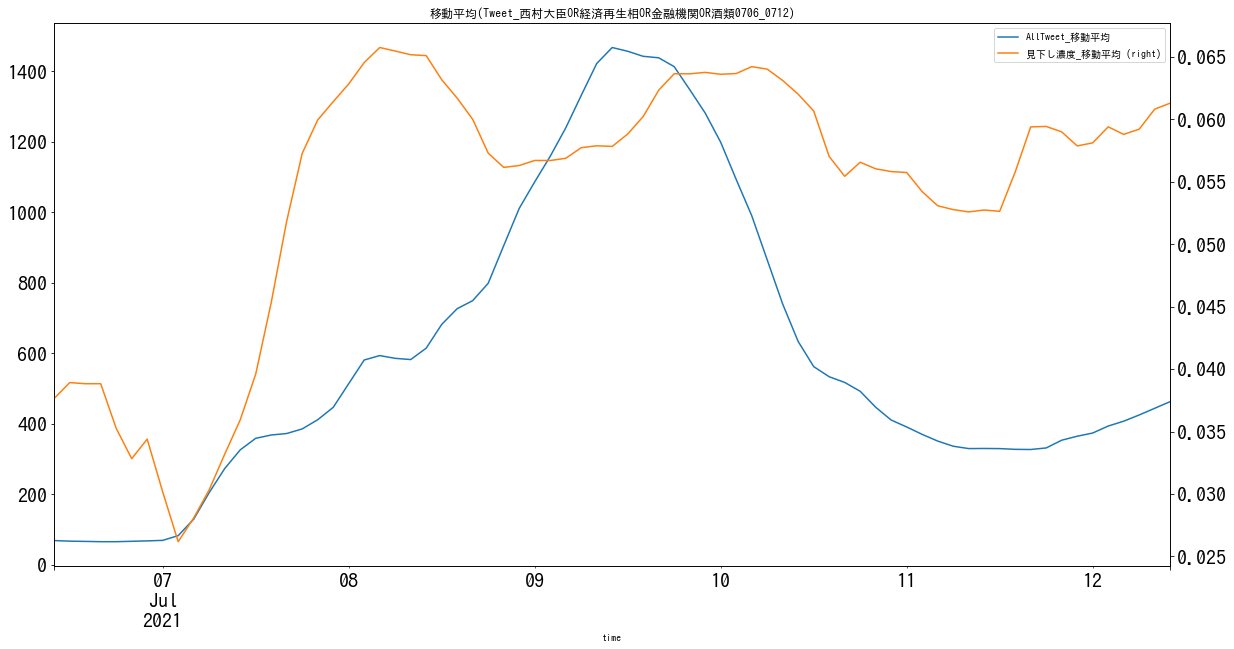

'\ntmp = DateTweetCnt(\'TweetData/オリンピック.csv\', mikudashi, peak = False, henka = False, zikosokan = True, since = "2021-01-26", end = "2021-02-08")\ntmp = DateTweetCnt(\'TweetData/Tweet_ドミノピザORバイトテロ.csv\', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)\ntmp = DateTweetCnt(\'TweetData/Tweet_フランスORグリーズマンORデンベレ.csv\', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)\ntmp = DateTweetCnt(\'TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv\', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)\ntmp = DateTweetCnt(\'TweetData/Tweet_開会式.csv\', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)\ntmp = DateTweetCnt(\'TweetData/Tweet_バッハORチャイニーズORIOC.csv\', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)\ntmp = DateTweetCnt(\'TweetData/報ステ.csv\', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)\ntmp = DateTweetCnt(\'TweetData/トイレットペーパー.csv\'

In [89]:
tmp = DateTweetCnt('../TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv', mikudashi)
"""
tmp = DateTweetCnt('TweetData/オリンピック.csv', mikudashi, peak = False, henka = False, zikosokan = True, since = "2021-01-26", end = "2021-02-08")
tmp = DateTweetCnt('TweetData/Tweet_ドミノピザORバイトテロ.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/Tweet_フランスORグリーズマンORデンベレ.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/Tweet_開会式.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/Tweet_バッハORチャイニーズORIOC.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/報ステ.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/トイレットペーパー.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/オリンピック.csv', mikudashi, peak = False, henka = False, zikosokan = True, since = "2021-04-01", end = "2021-05-01")
tmp = DateTweetCnt('TweetData/処理水.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
tmp = DateTweetCnt('TweetData/車椅子.csv', mikudashi, peak = False, henka = False, zikosokan = True, idoheikin = False)
"""

In [183]:
import os
os.cpu_count()

64

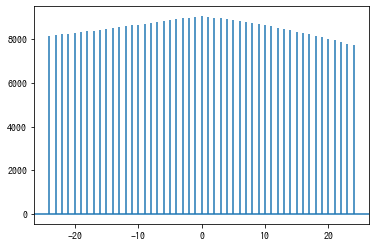

In [150]:
#相互相関係数の算出
import matplotlib.pyplot as plt
mikudashi = '馬鹿|アホ|バカ|クズ|呆れる|無能|クソ|能無し|キチガイ|低能|恥知らず|卑怯|間抜け|愚か|下衆|腰抜け|幼稚|偽善者|厚顔無恥|情弱|底辺層|無教養|乞食|マスゴミ|シナチョン|井の中の蛙|老害|ガイジ|池沼|無能|害悪|キモオタ|貧乏人|売国奴|愚か者|腰抜け|ノータリン|滑稽|国賊|政治屋|下劣|人非人|愚鈍|気狂い|マヌケ|愚劣|痴れ者|しょうもない|アンポンタン|嘘つき|生意気|浅はか|自業自得|無神経|軽蔑|情報弱者|ド低脳|莫迦|キモい|穀潰し|恥晒し|嘘吐き|無様'
    
def XCorr(filename, mikudashi,since = '',end = ''):
    tmp = DateTweetCnt(filename = filename, mikudashi=mikudashi, since = since, end = end, show = False)
    plt.xcorr(tmp["見下し濃度_移動平均"].to_list(),tmp["AllTweet_移動平均"].to_list(), normed=False, maxlags = 24,)

#XCorr('TweetData/Tweet_ドミノピザORバイトテロ.csv', mikudashi)
#XCorr('TweetData/報ステ.csv', mikudashi)
#XCorr('TweetData/Tweet_フランスORグリーズマンORデンベレ.csv', mikudashi)
#XCorr('TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv', mikudashi)
XCorr('TweetData/Tweet_感染者.csv', mikudashi)

[1.0, 0.9518946377781708, 0.84806567107744, 0.7274065989371692, 0.5822553185086005, 0.43520061460977316, 0.29921369165406647, 0.16294707835818406, 0.0839047964302166, 0.08674169262565912, 0.10615982916872468, 0.12744653234632364, 0.16247559152461735, 0.1915332479894162, 0.20984656159424744, 0.22780227411250362, 0.21910473089009122, 0.19128421787194563, 0.16509731493845037, 0.12902680836497224, 0.07670051631682509, 0.01850488736116533, -0.0355867702001606, -0.08215001815446103, -0.11865217646970189, -0.13567794008246062, -0.13017291087467917, -0.0845409746511284, 0.011649684420327473, 0.12649975134946018, 0.2511861200243923, 0.37658365729520427, 0.4686633332358432, 0.5066211394894926, 0.5088322662535136, 0.48028498597564084, 0.41267105684501415, 0.3053474209257136, 0.15899673075189777, -0.012918296663846616, -0.10592376388066366, -0.07123781647268596, 0.028349730430040562, 0.1690006636544939, 0.3510865469498834, 0.5343331277147816, 0.6778467287263169, 0.7687008064700969, 0.7635345523546

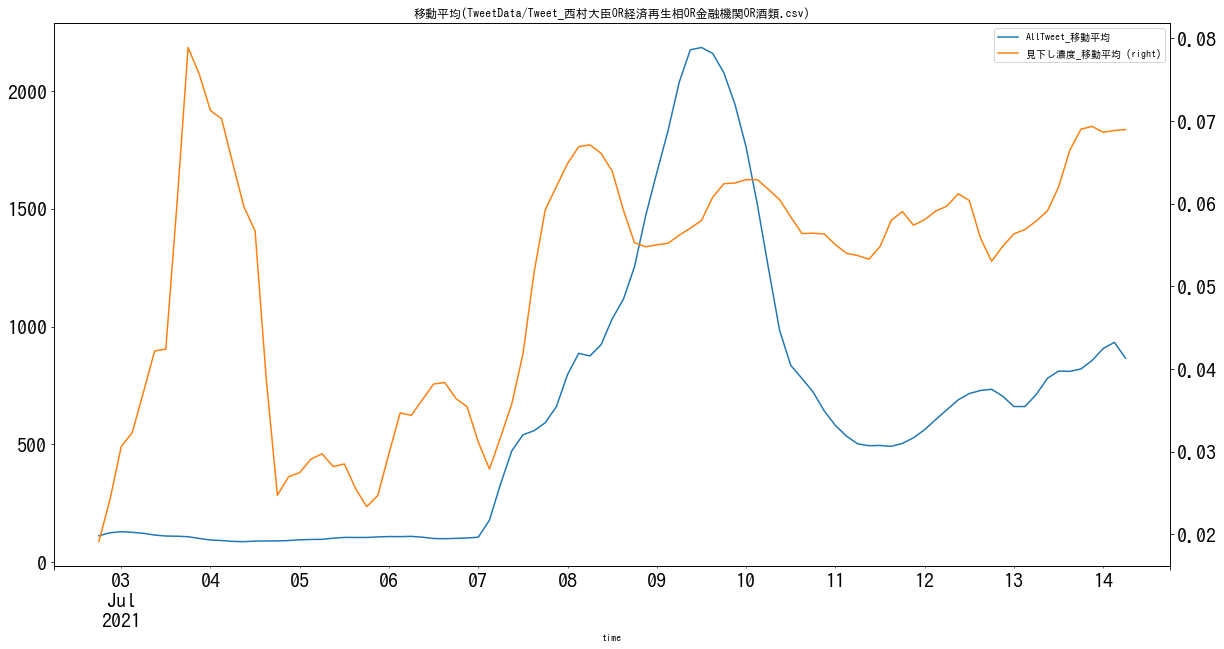

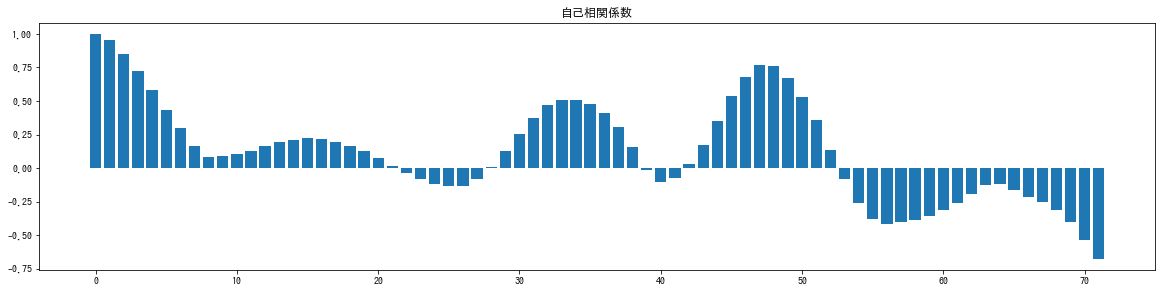

'\ntmp = DateTweetCnt(\'TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv\',mikudashi,\'見下し濃度_移動平均\')\ntmp = DateTweetCnt(\'TweetData/Tweet_開会式.csv\', mikudashi)\ntmp = DateTweetCnt(\'TweetData/Tweet_バッハORチャイニーズORIOC.csv\', mikudashi)\ntmp = DateTweetCnt(\'TweetData/報ステ.csv\', mikudashi,since = "2021-03-20", end = "2021-03-27")\ntmp = DateTweetCnt(\'TweetData/トイレットペーパー.csv\', mikudashi)\n'

In [159]:
#自己相関係数

mikudashi = '馬鹿|アホ|バカ|クズ|呆れる|無能|クソ|能無し|キチガイ|低能|恥知らず|卑怯|間抜け|愚か|下衆|腰抜け|幼稚|偽善者|厚顔無恥|情弱|底辺層|無教養|乞食|マスゴミ|シナチョン|井の中の蛙|老害|ガイジ|池沼|無能|害悪|キモオタ|貧乏人|売国奴|愚か者|腰抜け|ノータリン|滑稽|国賊|政治屋|下劣|人非人|愚鈍|気狂い|マヌケ|愚劣|痴れ者|しょうもない|アンポンタン|嘘つき|生意気|浅はか|自業自得|無神経|軽蔑|情報弱者|ド低脳|莫迦|キモい|穀潰し|恥晒し|嘘吐き|無様'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def AutoCorr(filename, mikudashi, colname, since = '',end = ''):
    # データを準備
    df = pd.read_csv(r'..//' + filename, sep = ',',parse_dates=True,index_col="time")
    #リンク付きのツイートを除外
    df = df[~df.contents.str.contains('http')]
    if since != '':
        df = df.loc[since:end]
    #各期間ごとにデータベースを作成
    date_tweetcount = df.resample('3H').count().contents
    #見下しツイートでも同じ処理を実行
    df_mikudashi = df[df.contents.str.contains(mikudashi)]
    date_tweetcount_mikudashi = df_mikudashi.resample('3H').count().contents
    #全ツイートと見下しツイートのマージ
    date_tweetcount2 = pd.merge(date_tweetcount,date_tweetcount_mikudashi, on = 'time',how = "outer").fillna(0)
    date_tweetcount2 = date_tweetcount2.rename(columns={'contents_x':'AllTweet','contents_y':'Mikudashi'})
    date_tweetcount2["見下し濃度"] = date_tweetcount2["Mikudashi"]/date_tweetcount2["AllTweet"]
    #tmp = date_tweetcount2.rolling(window = 3, center = True).mean()
    tmp = date_tweetcount2.rolling(window = 8).mean()
    tmp = tmp.shift(-4).rolling(window=2).mean()
    tmp = tmp.rename(columns={'AllTweet':'AllTweet_移動平均','Mikudashi':'Mikudashi_移動平均','見下し濃度':'見下し濃度_移動平均'})
    date_tweetcount2 = pd.concat([date_tweetcount2, tmp], axis = 1)
    tmp = date_tweetcount2.loc[:,["AllTweet_移動平均", "Mikudashi_移動平均","見下し濃度_移動平均"]].pct_change()
    tmp = tmp.rename(columns={'AllTweet_移動平均':'AllTweet_移動平均_変化率','Mikudashi_移動平均':'Mikudashi_移動平均_変化率','見下し濃度_移動平均':'見下し濃度_移動平均_変化率'})
    date_tweetcount2 = pd.concat([date_tweetcount2, tmp], axis = 1)
    df = date_tweetcount2[colname]
    ax1 = date_tweetcount2.loc[:,["AllTweet_移動平均"]].plot(figsize=(20,10))
    date_tweetcount2.loc[:,["見下し濃度_移動平均" ]].plot(title = "移動平均("+filename+")", figsize=(20,10),ax = ax1, secondary_y=True, fontsize=20)
    # lag=0から29までの自己相関係数
    lag = 72
    auto_series = [df.autocorr(lag=i) for i in range(lag)]
    print(auto_series)
    # 可視化
    fig = plt.figure(figsize=(20, 10))
    """"
    ax = fig.add_subplot(2, 1, 1, title="周期性のあるデータ")
    ax.plot(df.index, df)
    """
    ax = fig.add_subplot(2, 1, 2, title="自己相関係数")
    ax.bar(range(lag), auto_series)
    plt.show()

AutoCorr('TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv',mikudashi,'見下し濃度_移動平均')
#AutoCorr('TweetData/Tweet_感染者.csv',mikudashi,'見下し濃度_移動平均')
"""
AutoCorr('TweetData/Tweet_ドミノピザORバイトテロ.csv',mikudashi,'見下し濃度_移動平均')
AutoCorr('TweetData/Tweet_フランスORグリーズマンORデンベレ.csv',mikudashi, '見下し濃度_移動平均')
AutoCorr('TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv',mikudashi,'見下し濃度_移動平均')
AutoCorr('TweetData/Tweet_開会式.csv',mikudashi,'見下し濃度_移動平均')
AutoCorr('TweetData/トイレットペーパー.csv', mikudashi,'見下し濃度_移動平均')
"""
"""
tmp = DateTweetCnt('TweetData/Tweet_西村大臣OR経済再生相OR金融機関OR酒類.csv',mikudashi,'見下し濃度_移動平均')
tmp = DateTweetCnt('TweetData/Tweet_開会式.csv', mikudashi)
tmp = DateTweetCnt('TweetData/Tweet_バッハORチャイニーズORIOC.csv', mikudashi)
tmp = DateTweetCnt('TweetData/報ステ.csv', mikudashi,since = "2021-03-20", end = "2021-03-27")
tmp = DateTweetCnt('TweetData/トイレットペーパー.csv', mikudashi)
"""

In [156]:
tmp

[1.0,
 0.9518946377781708,
 0.84806567107744,
 0.7274065989371692,
 0.5822553185086005,
 0.43520061460977316,
 0.29921369165406647,
 0.16294707835818406,
 0.0839047964302166,
 0.08674169262565912,
 0.10615982916872468,
 0.12744653234632364,
 0.16247559152461735,
 0.1915332479894162,
 0.20984656159424744,
 0.22780227411250362,
 0.21910473089009122,
 0.19128421787194563,
 0.16509731493845037,
 0.12902680836497224,
 0.07670051631682509,
 0.01850488736116533,
 -0.0355867702001606,
 -0.08215001815446103]